# Exercise session 7: Sequential quadratic programming (SQP) methods

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import casadi as cs  # https://github.com/casadi/casadi

## Exercise 1: Equality-constrained SQP

$$
\min_{x,y}{0.5*x**2 + 0.5*(y/2)**2}
$$

$$
\text{subject to } (3 + (x-1)**2 - x) = y
$$

The solution to this problem is:

$$x^* = [0.793885, 2.2486]$$

$$\lambda^* = [-0.56215]$$

In [2]:
def ffun(xy: np.array):
    """Objective function f(x)"""
    x, y = xy
    f = 0.5 * x**2 + 0.5 * (y / 2) ** 2
    return f


def hfun(xy: np.array):
    """Equality constraint function h(x) = 0"""
    x, y = xy
    h = y - (3 + (x - 1) ** 2 - x)
    return np.array([h])


def gfun(xy):
    """Inequality constraint function g(x) <= 0"""
    x, y = xy

    g = -2 * x + 0.4 * x**2 + y
    return np.array([g])

In [3]:
def line_search(fun, x0, dir_deriv, dk, sigma, beta):
    """
    Line search using the Armijo conditions and backtracking.

    Input arguments:
    - fun: scalar function
    - x0: current iterate
    - dir_deriv: directional derivative of f at x0 in the direction dk
    - dk: search direction
    - sigma: armijo condition scalar parameter
    - beta: backtracking parameter

    Returns:
    - x: new iterate
    - alpha: step size
    """

    # Make sure sigma and beta are in a reasonable range
    if not 0 < sigma < 1:
        raise ValueError(f'sigma must be in (0, 1), but equals {sigma}')
    if not 0 < beta < 1:
        raise ValueError(f'beta must be in (0, 1), but equals {beta}')
    
    max_iter_left = 1000

    # Initialize alpha, evaluate function
    alpha = 1.
    f0 = fun(x0)

    x = x0 + alpha * dk

    while fun(x) > f0 + sigma * alpha * dir_deriv:
        # Trial step in x
        alpha *= beta
        x = x0 + alpha * dk

        max_iter_left -= 1

        # If the line search takes too many iterations, throw an exception
        if max_iter_left == 0:
            raise RuntimeError('Line search failed -- Too many iterations.')
    
    return x, alpha

In [4]:
def finite_difference_jacob(fun, x0):
    """
    Evaluates the Jacobian of fun at x0 using finite differences.

    Input arguments:
    - fun: real- or vector-valued function
    - x0: current iterate

    Returns:
    - f0: fun evaluated at x0 (as a 1D array)
    - J: Jacobian of fun evaluated at x0 (as a matrix)
    """
    
    # Make sure x0 is a 1D array
    x0 = np.atleast_1d(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"
    Nx = len(x0)

    # Make sure fun returns a 1D array
    f0 = np.atleast_1d(fun(x0))
    assert f0.ndim == 1, "fun must return a scalar or a 1D array"
    Nf = len(f0)

    # Initialize empty J
    J = np.zeros((Nf, Nx))

    # Perform the finite difference Jacobian evaluation
    h = 1e-8  # finite difference step size
    for k in range(Nx):
        x = np.copy(x0)
        x[k] += h
        f = fun(x)
        J[:, k] = (f - f0) / h

    return f0, J

In [5]:
def merit_fun(ffun, hfun, c, x):
    """
    Implementation of the merit function for equality-constrained problems
    
    Input arguments:
    - ffun: real-valued objective function
    - hfun: vector-valued equality constraint function
    - c: penalty parameter, strictly positive
    - x: the current iterate

    Returns:
    - the merit function φ(x; c) = f(x) + c ‖h(x)‖₁  evaluated at x
    """
    assert c > 0, "The penalty parameter c must be strictly positive."

    f = ffun(x)
    h = hfun(x)
    return f + c * np.linalg.norm(h, ord=1)

In [6]:
def minimize_eq_sqp(ffun, hfun, x0, with_line_search=True, with_powells_trick=False):
    """
    <inimizes the equality-constrained problem an SQP method

    Input arguments:
    - ffun: the objective function f, real-valued
    - hfun: the equality constraint function h, vector-valued
    - x0: the initial iterate

    Returns:
    - x: Final iterate
    - x_iters: Log of the iterates
    - x_grads: Log of the Lagrangian gradient norms
    """

    # Convergence tolerance
    convergence_tol = 1e-4
    max_iters = 1000

    # Check that x0 is a column vector
    x = np.asarray(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"

    # Make sure ffun returns a scalar
    f0 = ffun(x0)
    assert np.array(f0).ndim == 0, "ffun must return a scalar"

    # Make sure that hfun returns a column vector
    h0 = np.atleast_1d(hfun(x0))
    assert h0.ndim == 1, "hfun must return a 1D array"

    # Iteration logs
    x_iters = np.zeros((len(x0), max_iters))
    f_iters = np.zeros(max_iters)

    # Initialization
    x = np.copy(x0)
    lmbd = np.zeros_like(h0)
    B = np.identity(len(x0))  # BFGS matrix
    alpha = 0

    # Evaluate the initial f and its Jacobian J
    _, Jf = finite_difference_jacob(ffun, x)

    # Evaluate the initial h and its Jacobian J_h
    h, Jh = finite_difference_jacob(hfun, x)

    # Create a QP solver using CasADi
    n, m = len(x), len(h)
    # Define the sparsity pattern of the matrices, which is constant between
    # iterations (this allows the linear solver inside of the QP solver to
    # re-use the symbolic factorizations of the Hessian and the Jacobian)
    B_placeholder = cs.DM.ones(n, n)
    Jh_placeholder = cs.DM.ones(m, n)
    qp_struct = {'h': B_placeholder.sparsity(), 'a': Jh_placeholder.sparsity()}

    qp_solver_opts = {}
    qp_solver_opts["print_out"] = False
    qp_solver_opts["osqp"] = {"verbose": False,
                              "eps_abs": 1e-4,
                              "eps_rel": 1e-4,
                              "eps_prim_inf": 1e-5,
                              "eps_dual_inf": 1e-5,
                              "max_iter": 4000}

    qp_solver = cs.conic("qpsol", "osqp", qp_struct, qp_solver_opts)

    for k in range(max_iters):
        # Check for divergence
        if np.max(abs(x)) > 1e6:
            raise ValueError(f"minimize_eq_sqp has diverged, {np.max(abs(x))=}")

        # Update iteration log
        lagr_stat = np.linalg.norm(Jf.ravel() + Jh.T @ lmbd, ord=np.inf)
        infeas = np.linalg.norm(h, ord=np.inf)
        convergence_metric = np.maximum(lagr_stat, infeas)
        x_iters[:, k] = x
        f_iters[k] = convergence_metric

        # Iteration output
        fmt = "{0: >8}{1: >20}{2: >20}{3: >12}"
        if k % 10 == 0:
            print(fmt.format("iter", "||stationarity||", "||infeasibility||", "step size"))
        print(fmt.format(k, f"{lagr_stat:.7e}", f"{infeas:.7e}", f"{alpha:1.4f}"))

        # Check for convergence
        if convergence_metric < convergence_tol:
            return x, x_iters[:, 0 : k + 1], f_iters[0 : k + 1]

        x_old = np.copy(x)

        ###################### FILL THIS PART IN ####################

        grad_f = Jf.ravel()  # convert 1×n Jacobian matrix to 1D n-array

        # Find the search direction and new Lagrange multipliers
        if False: # Remember the old variant using a linear system:
            n, m = len(x), len(h)
            M = np.block([[B, Jh.T], [Jh, np.zeros((m, m))]])
            search_dir_x_lmbd = np.linalg.solve(M, np.concatenate([-grad_f, -h]))
            dk, lmbd = np.split(search_dir_x_lmbd, [n])

        # Solve the QP to recover the search direction and multipliers
        result = qp_solver(h=B,
                           a=Jh,
                           g=grad_f,
                           lba=-h,
                           uba=-h)
        # CasADi may return column vectors, so ravel them into 1D arrays
        dk = np.ravel(result['x'])
        lmbd = np.ravel(result['lam_a'])

        # Line search
        if with_line_search:
            c = 100
            eval_merit = lambda x: merit_fun(ffun, hfun, c, x)
            dir_deriv_merit = np.dot(grad_f, dk) - c * np.linalg.norm(h, ord=1)
            x, alpha = line_search(eval_merit, x, dir_deriv_merit, dk, sigma=0.01, beta=0.6)
        else:
            x += dk
            alpha = 1

        # Update BFGS Hessian approximation
        grad_f_old = np.copy(grad_f)
        Jh_old = np.copy(Jh)

        _, Jf = finite_difference_jacob(ffun, x)
        grad_f = Jf.ravel()
        h, Jh = finite_difference_jacob(hfun, x)

        # Note: both grad_Lx and grad_Lx_old use the latest value of λ
        grad_Lx_old = grad_f_old + Jh_old.T @ lmbd
        grad_Lx = grad_f + Jh.T @ lmbd

        s = x - x_old
        y = grad_Lx - grad_Lx_old
        Bs = B @ s

        # Powell's trick
        if with_powells_trick:
            sBs = np.dot(s, Bs)
            ys = np.dot(y, s)
            theta = 1 if ys >= 0.2 * sBs else (0.8 * sBs) / (sBs - ys)
            y = theta * y + (1 - theta) * Bs

        B = B - np.outer(Bs, Bs / np.dot(s, Bs)) + np.outer(y, y / np.dot(s, y))

        #############################################################

        # Symmetrize Hessian approximation (only needed for numerical accuracy)
        B = (B + B.T) / 2.0

    raise ValueError(f"minimize_eq_sqp has diverged, maximum number of iterations reached.")

In [7]:
def run_ex1_eq_sqp(with_line_search=True, with_powells_trick=False):
    variant = f"Line search={with_line_search}, Powell's trick={with_powells_trick}"
    # ------ Solve the problem ------
    # Initial guess
    x0 = np.array([3.0, 1.0])

    _, x, gradients_lagrangian = minimize_eq_sqp(ffun,
                                                 hfun,
                                                 x0,
                                                 with_line_search,
                                                 with_powells_trick)

    plt.figure()
    X, Y = np.meshgrid(np.linspace(-1.0, 4.0, 40), np.linspace(-3.0, 4.0, 40))
    obj = np.vectorize(lambda x, y: ffun([x, y]))(X, Y)

    c = plt.contour(X, Y, obj, 40)
    t = np.linspace(-1.0, 4, 400)
    plt.plot(t, 3.0 + np.square(t - 1.0) - t, "k", label="Constraint")
    plt.xlim([-1.0, 4.0])
    plt.ylim([-3.0, 4.0])

    # Plot iterates
    plt.plot(x[0, :], x[1, :], "r.-", label="Iterates")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Iterates of equality constrained SQP ({variant})")
    plt.legend()

    # Plot convergence
    plt.figure()
    plt.semilogy(gradients_lagrangian, ".-")
    plt.grid(True)
    plt.title(f"Lagrangian gradient norm at each iteration ({variant})")
    plt.xlabel("iterations")
    plt.ylabel(r"$\|\nabla L(x_k, \lambda_k)\|_\infty$")
    plt.show()

    iter    ||stationarity||   ||infeasibility||   step size
       0       3.0000000e+00       3.0000000e+00      0.0000
       1       1.4662500e+00       1.6256250e+00      1.0000
       2       1.2885752e+02       3.5675824e+02      1.0000
       3       3.2561256e+01       8.9837491e+01      1.0000
       4       8.4910839e+00       2.3434568e+01      1.0000
       5       2.5473302e+00       7.1191674e+00      1.0000
       6       1.4844363e+00       4.2313134e+00      1.0000
       7       1.9869134e+01       4.8406463e+01      1.0000
       8       5.3665072e+00       1.3122137e+01      1.0000
       9       1.8464880e+00       4.6850658e+00      1.0000
    iter    ||stationarity||   ||infeasibility||   step size
      10       2.3503933e+00       6.9914112e+00      1.0000
      11       1.6197767e+00       3.4057584e+00      1.0000
      12       7.5038950e+00       2.3549552e+01      1.0000
      13       1.3663869e+00       5.9882338e+00      1.0000
      14       2.4289653

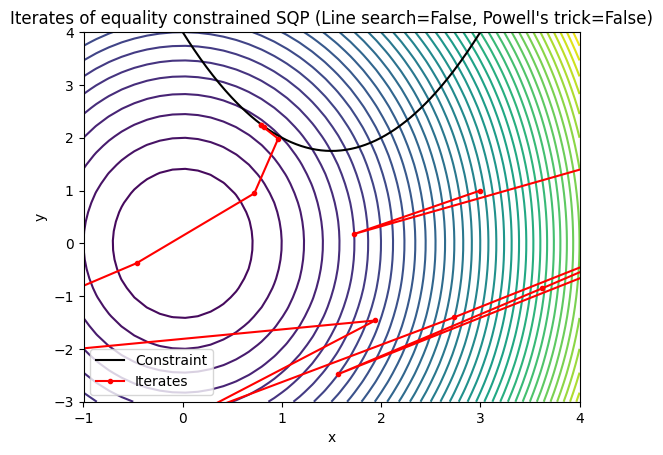

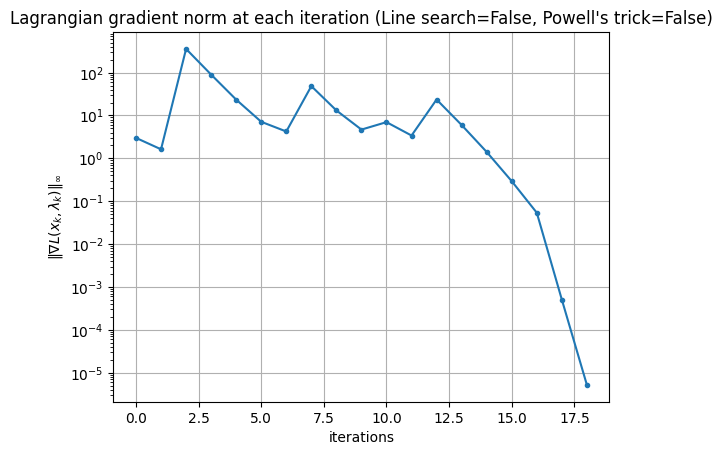

    iter    ||stationarity||   ||infeasibility||   step size
       0       3.0000000e+00       3.0000000e+00      0.0000
       1       1.4662500e+00       1.6256250e+00      1.0000
       2       3.2732268e+00       1.6237768e+00      0.0022
       3       1.4254644e+00       8.8860833e-02      1.0000
       4       1.1205084e+00       7.6628941e-02      0.6000
       5       8.4477564e-01       7.3346953e-02      0.1296
       6       5.4182029e-01       6.8759489e-02      0.3600
       7       1.6459465e-02       6.4620395e-02      1.0000
       8       3.6621842e-03       1.6827858e-04      1.0000
       9       4.3930718e-06       1.8380941e-06      1.0000


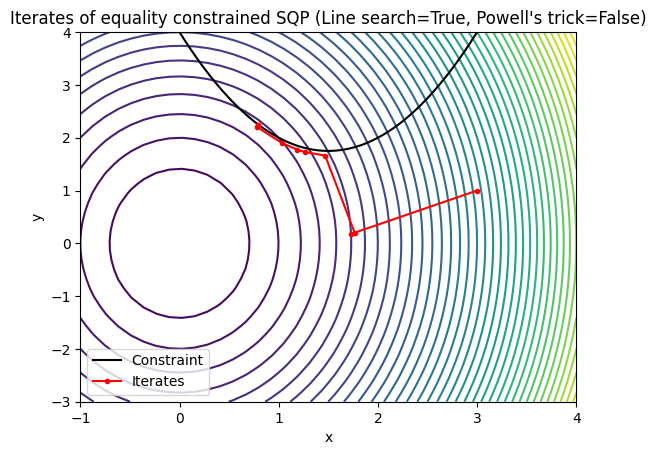

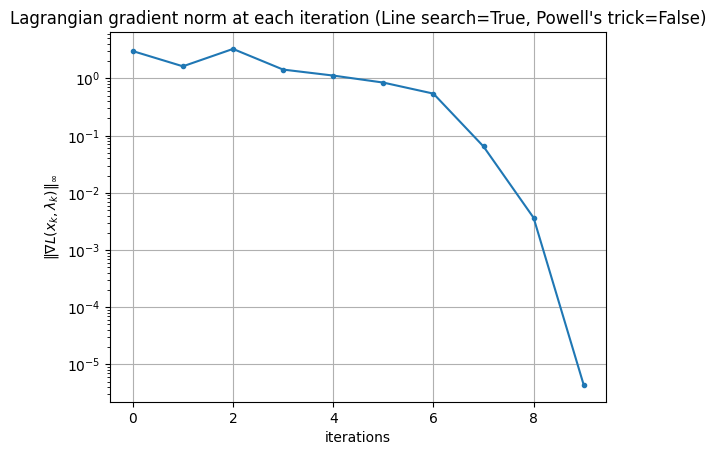

    iter    ||stationarity||   ||infeasibility||   step size
       0       3.0000000e+00       3.0000000e+00      0.0000
       1       1.4662500e+00       1.6256250e+00      1.0000
       2       2.2392547e+01       7.6588495e+01      1.0000
       3       5.1448430e+00       1.9257656e+01      1.0000
       4       8.4881470e-01       4.9343742e+00      1.0000
       5       3.5052755e-01       1.3484084e+00      1.0000
       6       5.9424889e-01       1.6577297e-01      1.0000
       7       2.9397589e-01       3.4684113e-02      1.0000
       8       2.9260457e-02       2.7330754e-02      1.0000
       9       2.0290515e-03       4.8315418e-05      1.0000
    iter    ||stationarity||   ||infeasibility||   step size
      10       2.9378599e-06       1.6866217e-06      1.0000


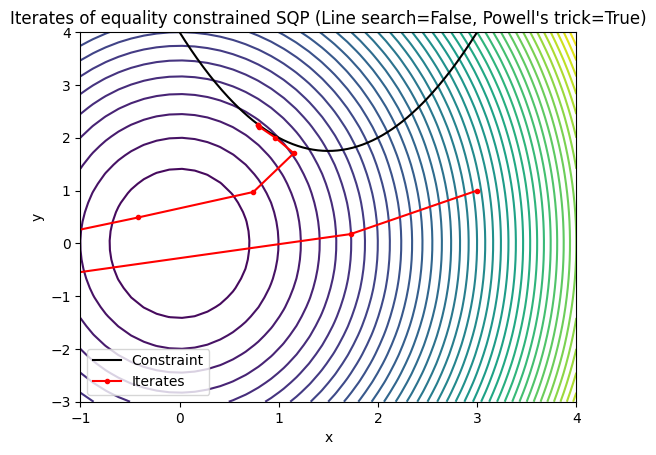

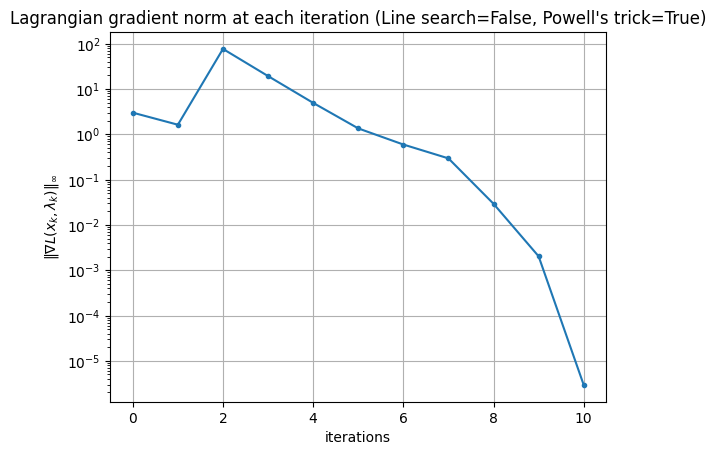

    iter    ||stationarity||   ||infeasibility||   step size
       0       3.0000000e+00       3.0000000e+00      0.0000
       1       1.4662500e+00       1.6256250e+00      1.0000
       2       1.7185924e+00       1.6199272e+00      0.0168
       3       1.1261472e+00       2.9475094e-01      1.0000
       4       2.6894432e-01       1.8397006e-02      1.0000
       5       4.9708995e-02       9.4360142e-03      1.0000
       6       2.2432460e-03       8.3249523e-05      1.0000
       7       5.3913192e-05       1.6323919e-06      1.0000


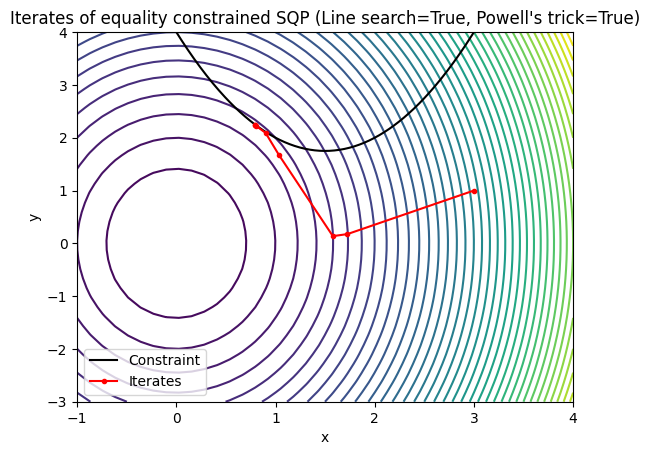

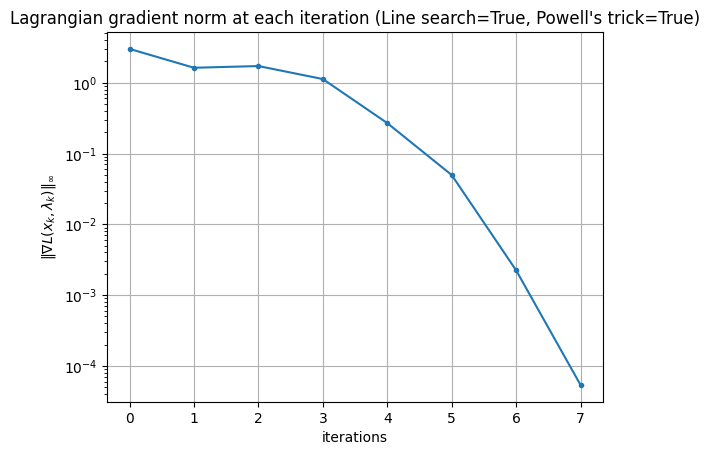

In [8]:
# No linesearch, no Powell
run_ex1_eq_sqp(with_line_search=False, with_powells_trick=False)
# Only linesearch
run_ex1_eq_sqp(with_line_search=True, with_powells_trick=False)
# Only Powell's trick
run_ex1_eq_sqp(with_line_search=False, with_powells_trick=True)
# Linesearch and Powell's trick
run_ex1_eq_sqp(with_line_search=True, with_powells_trick=True)

## Exercise 2: Inequality-constrained SQP

In [9]:
def merit_fun(ffun, hfun, gfun, c, x):
    """
    Implementation of the merit function for general constrained problems

    Input arguments:
    - ffun: real-valued objective function
    - hfun: vector-valued equality constraint function
    - gfun: vector-valued inequality constraint function
    - c: penalty parameter, strictly positive
    - x: the current iterate

    Returns:
    - the merit function φ(x; c) = f(x) + c ‖h(x)‖₁ + c ‖[g(x)]₊‖₁ evaluated at x
    """
    assert c > 0, "The penalty parameter c must be strictly positive."

    f = ffun(x)
    h = hfun(x)
    g = gfun(x)
    return f + c * np.linalg.norm(h, ord=1) + c * np.linalg.norm(np.fmax(g, 0), ord=1)

In [10]:
def minimize_sqp(ffun, hfun, gfun, x0, with_line_search=True, with_powells_trick=False, callback=None):
    """
    Minimizes the constrained problem an SQP method

    Input arguments:
    - ffun: the objective function f, real-valued
    - hfun: the equality constraint function h, vector-valued
    - gfun: the inequality constraint function h, vector-valued
    - x0: the initial iterate

    Returns:
    - x: Final iterate
    - x_iters: Log of the iterates
    - x_grads: Log of the Lagrangian gradient norms
    """

    # Convergence tolerance
    convergence_tol = 1e-4
    max_iters = 1000

    # Check that x0 is a column vector
    x = np.asarray(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"

    # Make sure ffun returns a scalar
    f0 = ffun(x0)
    assert np.array(f0).ndim == 0, "ffun must return a scalar"

    # Make sure that hfun returns a column vector
    h0 = np.atleast_1d(hfun(x0))
    assert h0.ndim == 1, "hfun must return a 1D array"

    # Make sure that gfun returns a column vector
    g0 = np.atleast_1d(gfun(x0))
    assert g0.ndim == 1, "gfun must return a 1D array"

    # Iteration logs
    x_iters = np.zeros((len(x0), max_iters))
    f_iters = np.zeros(max_iters)

    # Initialization
    x = np.copy(x0)
    lmbd = np.zeros_like(h0)
    mu = np.zeros_like(g0)
    B = np.identity(len(x0))  # BFGS matrix
    alpha = 0
    qp_status = "-"

    # Evaluate the initial f and its Jacobian J
    _, Jf = finite_difference_jacob(ffun, x)

    # Evaluate the initial h and its Jacobian J_h
    h, Jh = finite_difference_jacob(hfun, x)

    # Evaluate the initial g and its Jacobian J_g
    g, Jg = finite_difference_jacob(gfun, x)

    # Create a QP solver using CasADi
    n, m_eq, m_ineq = len(x), len(h), len(g)
    # Define the sparsity pattern of the matrices, which is constant between
    # iterations (this allows the linear solver inside of the QP solver to
    # re-use the symbolic factorizations of the Hessian and the Jacobian)

    # Define the QP solver with Casadi
    B_placeholder = cs.DM.ones(n, n)
    Jhg_placeholder = cs.DM.ones(m_eq + m_ineq, n)
    qp_struct = {'h': B_placeholder.sparsity(), 'a': Jhg_placeholder.sparsity()}

    qp_solver_opts = {}
    qp_solver_opts["print_out"] = False
    qp_solver_opts["printLevel"] = "none"

    qp_solver = cs.conic("qpsol", "qpoases", qp_struct, qp_solver_opts)

    for k in range(max_iters):
        # Check for divergence
        if np.max(abs(x)) > 1e6:
            raise ValueError(f"minimize_eq_sqp has diverged, {np.max(abs(x))=}")

        # Update iteration log
        lagr_stat = np.linalg.norm(Jf.ravel() + Jh.T @ lmbd + Jg.T @ mu, ord=np.inf)
        infeas = np.linalg.norm(np.concatenate((h, np.fmax(g, 0))), ord=np.inf)
        conv_metric = np.maximum(lagr_stat, infeas)
        x_iters[:, k] = x
        f_iters[k] = conv_metric

        # Iteration output
        fmt = "{: >8}{: >20}{: >20}{: >20}{: >12}"
        if k % 10 == 0:
            print(fmt.format("iter", "QP status", "||stationarity||", "||infeasibility||", "step size"))
        print(fmt.format(k, qp_status, f"{lagr_stat:.7e}", f"{infeas:.7e}", f"{alpha:1.4f}"))

        # Callback to optionally plot intermediate iterates
        if callback is not None:
            callback(x)

        # Check for convergence
        if conv_metric < convergence_tol:
            return x, x_iters[:, 0 : k + 1], f_iters[0 : k + 1]

        x_old = np.copy(x)

        ###################### FILL THIS PART IN ####################

        grad_f = Jf.ravel()  # convert 1×n Jacobian matrix to 1D n-array

        # Solve the QP to recover the search direction and multipliers
        result = qp_solver(h=B,
                           a=np.vstack((Jh, Jg)),
                           g=grad_f,
                           lba=np.concatenate((-h, -np.inf * np.ones_like(g))),
                           uba=np.concatenate((-h, -g)))
        # CasADi may return column vectors, so ravel them into 1D arrays
        dk = np.ravel(result['x'])
        lmbd, mu = np.split(np.ravel(result['lam_a']), [len(h)])
        qp_status = qp_solver.stats()['return_status']

        # Line search
        if with_line_search:
            c = 100
            eval_merit = lambda x: merit_fun(ffun, hfun, gfun, c, x)
            nrm_1 = lambda v: np.linalg.norm(v, ord=1)
            dir_deriv_merit = np.dot(grad_f, dk) - c * nrm_1(h) - c * nrm_1(np.fmax(g, 0))
            x, alpha = line_search(eval_merit, x, dir_deriv_merit, dk, sigma=0.01, beta=0.6)
        else:
            x += dk
            alpha = 1

        # Update BFGS Hessian approximation
        grad_f_old = np.copy(grad_f)
        Jh_old = np.copy(Jh)
        Jg_old = np.copy(Jg)

        _, Jf = finite_difference_jacob(ffun, x)
        grad_f = Jf.ravel()
        h, Jh = finite_difference_jacob(hfun, x)
        g, Jg = finite_difference_jacob(gfun, x)

        # Note: both grad_Lx and grad_Lx_old use the latest values of λ, μ
        grad_Lx_old = grad_f_old + Jh_old.T @ lmbd + Jg_old.T @ mu
        grad_Lx = grad_f + Jh.T @ lmbd + Jg.T @ mu

        s = x - x_old
        y = grad_Lx - grad_Lx_old
        Bs = B @ s

        # Powell's trick
        if with_powells_trick:
            sBs = np.dot(s, Bs)
            ys = np.dot(y, s)
            theta = 1 if ys >= 0.2 * sBs else (0.8 * sBs) / (sBs - ys)
            y = theta * y + (1 - theta) * Bs

        B = B - np.outer(Bs, Bs / np.dot(s, Bs)) + np.outer(y, y / np.dot(s, y))

        #############################################################

        # Symmetrize Hessian approximation (only needed for numerical accuracy)
        B = (B + B.T) / 2.0

    raise ValueError(f"minimize_eq_sqp has diverged, maximum number of iterations reached.")

In [11]:
def run_ex2_sqp(with_line_search=True, with_powells_trick=False):
    variant = f"Line search={with_line_search}, Powell's trick={with_powells_trick}"
    # ------ Solve the problem ------
    # Initial guess
    x0 = np.array([3.0, 1.0])

    _, x, gradients_lagrangian = minimize_sqp(ffun,
                                              hfun,
                                              gfun,
                                              x0,
                                              with_line_search,
                                              with_powells_trick)

    plt.figure()
    X, Y = np.meshgrid(np.linspace(-1.0, 4.0, 40), np.linspace(-3.0, 4.0, 40))
    obj = np.vectorize(lambda x, y: ffun([x, y]))(X, Y)

    c = plt.contour(X, Y, obj, 40)
    t = np.linspace(-1.0, 4, 400)
    plt.plot(t, 3.0 + np.square(t - 1.0) - t, "k", label="Equality constraint")
    plt.plot(t, 2 * t - 0.4 * t**2, "k--", label="Inequality constraint")
    plt.xlim([-1.0, 4.0])
    plt.ylim([-3.0, 4.0])

    # Plot iterates
    plt.plot(x[0, :], x[1, :], "r.-", label="Iterates")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Iterates of equality constrained SQP ({variant})")
    plt.legend()

    # Plot convergence
    plt.figure()
    plt.semilogy(gradients_lagrangian, ".-")
    plt.grid(True)
    plt.title(f"Lagrangian gradient norm at each iteration ({variant})")
    plt.xlabel("iterations")
    plt.ylabel(r"$\|\nabla L(x_k, \lambda_k, \mu_k)\|_\infty$")
    plt.show()


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter           QP status    ||stationarity||   ||infeasibility||   step size
       0                   -       3.0000000e+00       3.0000000e+00      0.0000
       1  Successful return.       1.4662500e+00       1.6256250e+00      1.0000
       2  Successful return.       1.0263780e+02       7.2939699e+00      1.0000
       3  Successful return.       2.5113826e+01       1.7441900e+00      1.0000
       4  Successful return.       5.7343509e+00       3.6638470e-01      1.0000
       5  Successful return.      

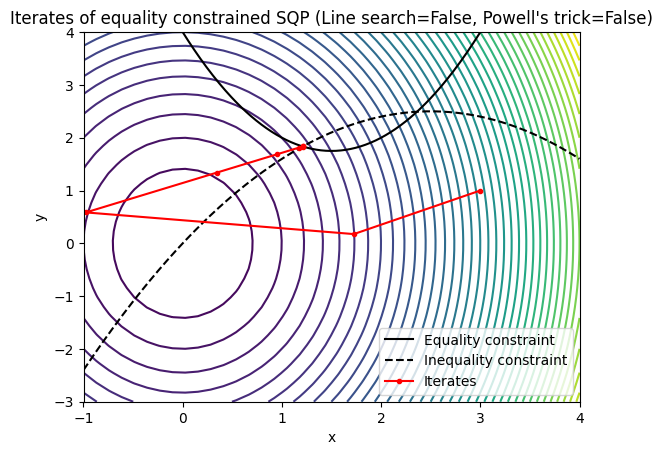

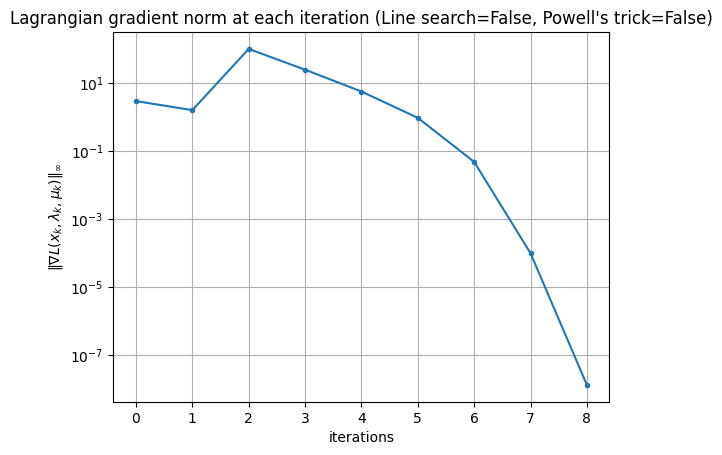


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter           QP status    ||stationarity||   ||infeasibility||   step size
       0                   -       3.0000000e+00       3.0000000e+00      0.0000
       1  Successful return.       1.4662500e+00       1.6256250e+00      1.0000
       2  Successful return.       2.2621370e+01       1.6147975e+00      0.2160
       3  Successful return.       1.9773764e+00       4.1714686e-03      1.0000
       4  Successful return.       8.0774010e-02       1.2954885e-05      1.0000
       5  Successful return.      

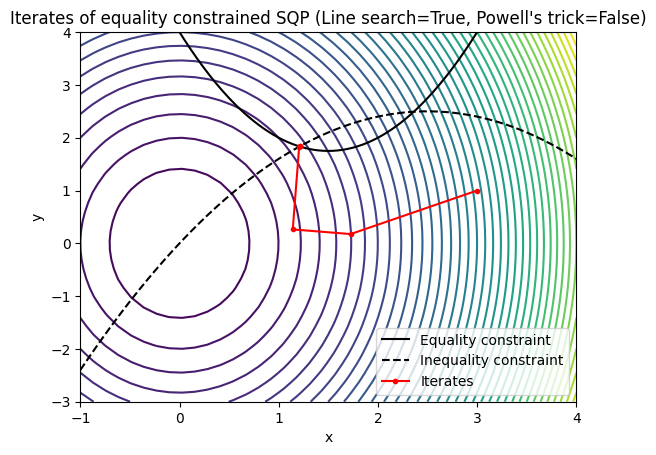

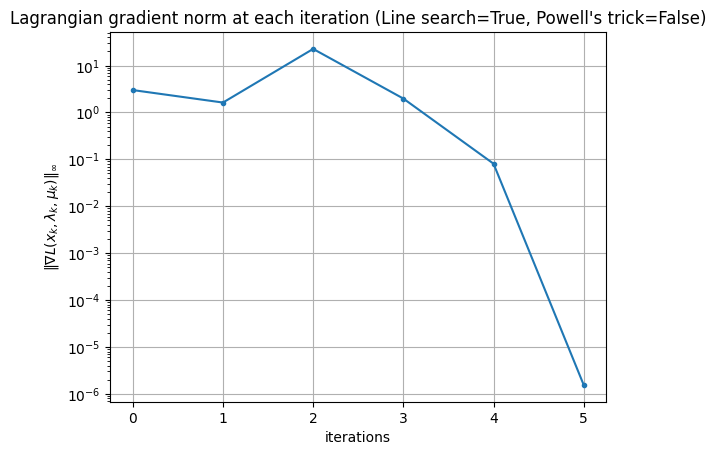


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter           QP status    ||stationarity||   ||infeasibility||   step size
       0                   -       3.0000000e+00       3.0000000e+00      0.0000
       1  Successful return.       1.4662500e+00       1.6256250e+00      1.0000
       2  Successful return.       6.6868959e+01       7.2939699e+00      1.0000
       3  Successful return.       1.6350758e+01       1.7441899e+00      1.0000
       4  Successful return.       3.6374764e+00       3.6638467e-01      1.0000
       5  Successful return.      

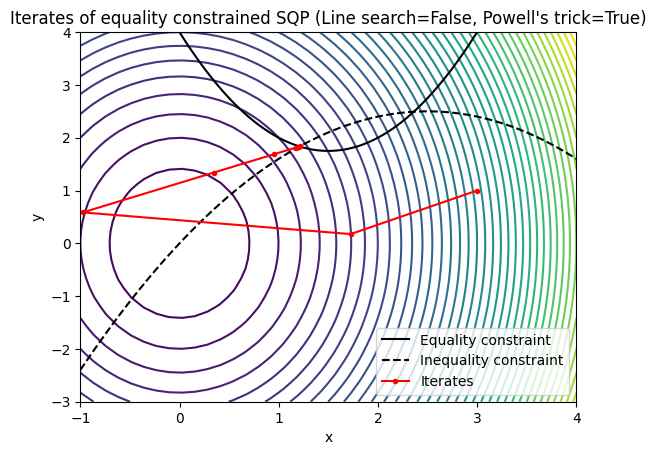

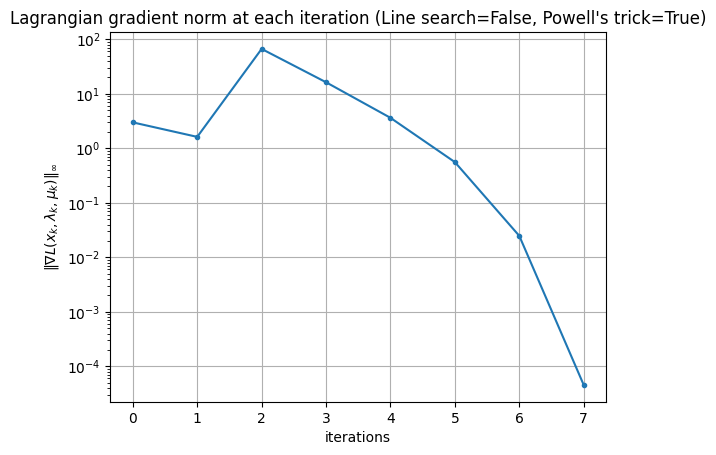


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter           QP status    ||stationarity||   ||infeasibility||   step size
       0                   -       3.0000000e+00       3.0000000e+00      0.0000
       1  Successful return.       1.4662500e+00       1.6256250e+00      1.0000
       2  Successful return.       1.3617583e+01       1.6147975e+00      0.2160
       3  Successful return.       1.2786029e+00       4.1715035e-03      1.0000
       4  Successful return.       6.8154042e-02       1.2954885e-05      1.0000
       5  Successful return.      

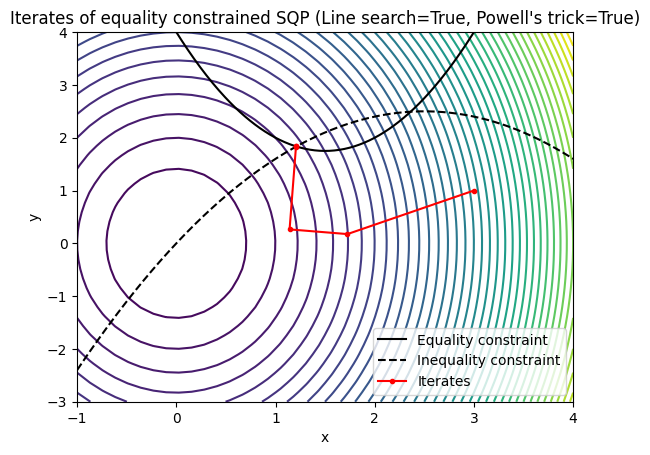

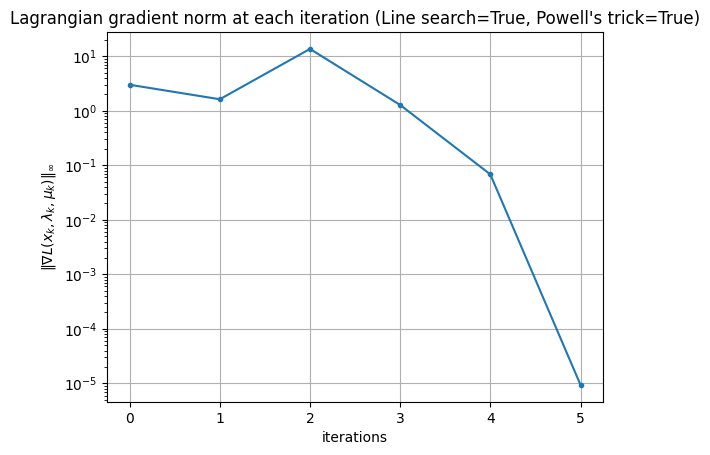

In [12]:
# No linesearch, no Powell
run_ex2_sqp(with_line_search=False, with_powells_trick=False)
# Only linesearch
run_ex2_sqp(with_line_search=True, with_powells_trick=False)
# Only Powell's trick
run_ex2_sqp(with_line_search=False, with_powells_trick=True)
# Linesearch and Powell's trick
run_ex2_sqp(with_line_search=True, with_powells_trick=True)

## Exercise 3: Hanging chain

In [13]:
def ffun(xy: np.array):
    x, y = np.reshape(xy, (2, -1))

    V = np.sum(y)
    return V

def hfun(xy):
    x, y = np.reshape(xy, (2, -1))
    r = 2.8 / len(x)

    h = (x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 - r**2
    h = np.concatenate((h, [x[0] + 1], [x[-1] - 1], [y[0] - 1], [y[-1] - 1]))
    return h

def gfun_linear(xy):
    x, y = np.reshape(xy, (2, -1))

    g = 0.15 * x + 0.3 - y # convex
    return g

def gfun_quadratic(xy):
    x, y = np.reshape(xy, (2, -1))

    g = -0.6 * x**2 + 0.15 * x + 0.5 - y # non-convex
    return g


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

    iter           QP status    ||stationarity||   ||infeasibility||   step size
       0                   -       1.0000001e+00       8.5196676e-03      0.0000
       1  Successful return.       9.7872119e+01       7.0938031e-03      0.2160
       2  Successful return.       5.7567611e+00       6.9609758e-03      0.0778
       3  Successful return.       4.4349872e+00       9.3614907e-03      0.0778
       4  Successful return.       3.6639381e+00       9.6065506e-03      0.0101
       5  Successful return.      

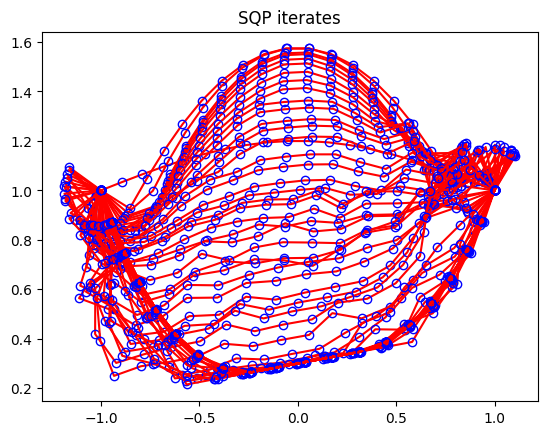

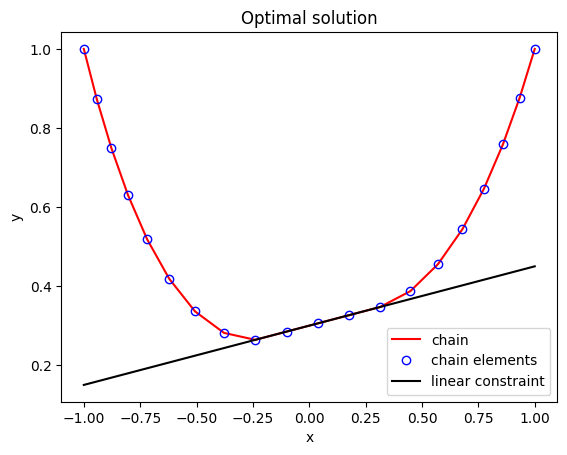

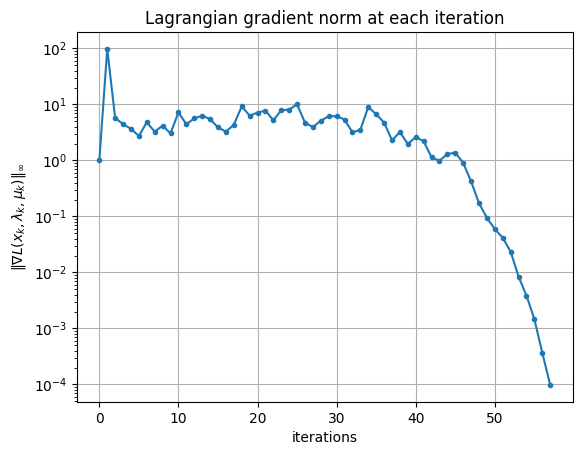

In [14]:
N = 20
linear_constraints = True

x0 = np.linspace(-1, 1, N)

# Different initial guesses for y
y0 = np.ones(N)
y0 = 1 + 0.2 * np.cos(x0 * np.pi / 2)

if linear_constraints:
    gfun = gfun_linear
else:
    gfun = gfun_quadratic

xy0 = np.concatenate((x0, y0))

# Plot the intermediate iterates
plt.figure()
plt.title("SQP iterates")

def callback(xy):
    x, y = np.reshape(xy, (2, -1))
    plt.plot(x, y, "r")
    plt.plot(x, y, "bo", mfc="none")

xy ,_, gradients_lagrangian = minimize_sqp(ffun, hfun, gfun, xy0, with_line_search=True, with_powells_trick=True, callback=callback)

# ------ Plot the solution ------
fig1 = plt.figure()
x, y = np.reshape(xy, (2, -1))
plt.plot(x, y, "r", label="chain")
plt.plot(x, y, "bo", label="chain elements", mfc="none")

if linear_constraints:
    plt.plot(x, 0.15 * x+0.3, color="k", label="linear constraint")
else:
    plt.plot(x, -0.6 * x**2 +0.15 * x + 0.5, color="k", label="quadratic constraint")

title_str = "Optimal solution"
plt.title(title_str)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Plot convergence
plt.figure()
plt.semilogy(gradients_lagrangian, ".-")
plt.grid(True)
plt.title(f"Lagrangian gradient norm at each iteration")
plt.xlabel("iterations")
plt.ylabel(r"$\|\nabla L(x_k, \lambda_k, \mu_k)\|_\infty$")
plt.show()